# Examen 2 - Métodos Bayesianos - Práctico.


## 1. Modelo de mezclas para cuantización óptima de colores en una imagen

Referencia: https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html

Las imágenes fotográficas, especialmente las obtenidas con buenas cámaras, pueden requerir una gran cantidad de colores para mostrarse. 

Sin embargo, las imágenes normalmente son estructuras de datos supremamente redundantes en el sentido de que dos pixeles adyacentes suelen ser similares en cuanto a la composición de color. Este hecho permite reducir el número de colores necesarios para "pintar" una imagen considerablemente, conservando la apariencia al ojo humano.

Una manera de hacer lo anterior es utilizar un algoritmo de clustering sobre los datos de intensidad de color en los pixeles, y en lugar de pintar las intensidades de colores originales, se pinta el centroide correspondiente a cada pixel.

In [1]:
# Importamos librerías
from sklearn.datasets import load_sample_image
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import Normalizer
from scipy.stats import multivariate_normal
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Comúnmente, las intensidades de los colores RGB en una imagen se representan con enteros de 0 a 255. Para tratar estos datos numéricamente nos conviene convertirlos a números flotantes de 0 a 1.

In [2]:
# Cargamos imagen
china = load_sample_image("china.jpg")
china = np.array(china, dtype=np.float64) / 255

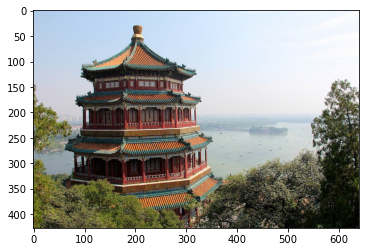

In [3]:
# Mostramos la imagen original
plt.figure()
plt.imshow(china)

Observamos que una imagen es un arreglo tridimensional de altura, largo y las 3 intensidades de colores RGB.

In [4]:
china.shape

(427, 640, 3)

De modo que para considerar los datos de cada pixel lo que hacemos es un reshape:

In [5]:
# Shape
w, h, d = china.shape
image_array = np.reshape(china, (w * h, d))

¿Cuántos colores distintos nos muestra esta imagen?

In [6]:
# Número de colores diferentes en la imagen
len(np.unique(image_array, axis=0))

96615

La buena noticia es que como ya dijimos las imágenes son estructuras de datos sumamente redundantes. Esto nos habilita a hacer el clustering simplemente sobre un subconjunto de todos los datos, digamos 1000 pixeles:

In [7]:
# Subconjunto de pixeles para hacer el clustering
image_array_sample = image_array[np.random.randint(low=0, high=w * h, size=1000), :]
image_array_sample

array([[0.22352941, 0.23921569, 0.14901961],
       [0.15294118, 0.14901961, 0.18039216],
       [0.96078431, 0.90196078, 0.73333333],
       ...,
       [0.03529412, 0.04705882, 0.01960784],
       [0.47843137, 0.55294118, 0.5372549 ],
       [0.75686275, 0.83921569, 0.92156863]])

### 1.1.

Entrenar un modelo de mezclas Gaussianas sobre el subconjunto de pixeles, usando 100 componentes.

In [8]:
# Definir el número de colores finales (número de componentes de la mezcla Gaussiana)
n_colors = 100

In [9]:
# Instanciar y entrenar el modelo
gmm = GaussianMixture(n_components=n_colors)
gmm.fit(image_array_sample)

GaussianMixture(n_components=100)

In [10]:
# Predecir el componente (color) más probable para cada pixel
labels = gmm.predict(image_array)

La siguiente función convierte las predicciones `labels` en el formato de imagen:

In [11]:
def recreate_image(codebook, labels, w, h):
    """
    Recreate the (compressed) image from the code book & labels
    """
    return codebook[labels].reshape(w, h, -1)

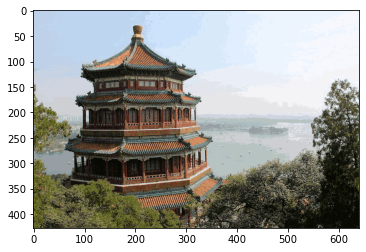

In [12]:
# Imagen con 100 colores
plt.figure()
plt.imshow(recreate_image(gmm.means_, labels, w, h))

¿Qué tal funciona?

### 1.2.
Ahora, elijamos el número óptimo de colores de acuerdo a la log-verosimilitud del GMM.

Recordemos la función de log verosimilitud para el modelo de mezclas Gaussianas:

$$
\log p(X |\theta) = \sum_{i=1}^{N} \log \left(\sum_{c=1}^{k}\pi_c \mathcal{N}(x_i | \mu_c, \Sigma_c)\right)
$$

In [13]:
def log_likelihood_gmm(X, mu, sigma, pi):
    """
    Log-likelihood of the data wrt Gaussian Mixture Model.
    :param data: Data.
    :param mu: Means of the components of the GMM.
    :param sigma: Covariances of the components of the GMM.
    :param pi: Weights of the components of the GMM.
    :return: Log-likelihood of the data wrt GMM.
    """
    # Number of clusters
    k = mu.shape[0]
    # Number of points
    N = X.shape[0]
    
    # Individual likelihood of each point to each normal
    ind_likelihood = np.zeros((N, k))
    for j in range(k):
        ind_likelihood[:, j] = multivariate_normal.pdf(X, mean=mu[j, :], cov=sigma[j, :, :])
    
    # Log likelihood
    log_likelihood = np.log(ind_likelihood.dot(pi)).mean()
        
    return log_likelihood

Partimos los datos en entrenamiento y prueba:

In [14]:
# Importamos sklearn.model_selection.train_test_split
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test = train_test_split(image_array_sample, test_size=0.2)

Para 5 hasta 100 colores encontrar la log verosimilitud en los datos de entrenamiento y en los datos de prueba:

In [16]:
log_likelihood_train = []
log_likelihood_test = []
# Escribe tu código aquí
for k in range(5, 101):
    # Instanciamos el algoritmo
    gmm = GaussianMixture(n_components=k)
    
    # Entrenamos
    gmm.fit(X=X_train)
    pi = gmm.weights_
    mu = gmm.means_
    sigma = gmm.covariances_
    
    # Métrica con datos de entrenamiento
    log_likelihood_train.append(log_likelihood_gmm(X_train, mu, sigma, pi))
    # Métrica con datos de prueba
    log_likelihood_test.append(log_likelihood_gmm(X_test, mu, sigma, pi))

Graficar y de acuerdo al gráfico, recomendar un número de colores donde se obtenga una buena log-verosimilitud sobre los datos de prueba:

Text(0, 0.5, 'Log-verosimilitud')

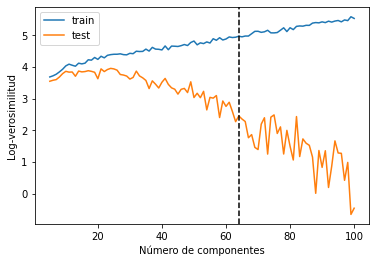

In [17]:
plt.plot(range(5, 101), log_likelihood_train, label="train")
plt.plot(range(5, 101), log_likelihood_test, label="test")
plt.axvline(x=50, ls="--", color="k")
plt.legend()
plt.xlabel("Número de componentes")
plt.ylabel("Log-verosimilitud")
#plt.axis([50,80,5,5.50])

Reentrenar el modelo con el número de colores elegido y mostrar la imagen comprimida:

In [18]:
# Definir el número de colores finales (número de componentes de la mezcla Gaussiana)
n_colors = 64
# Instanciar y entrenar el modelo
gmm_64 = GaussianMixture(n_components=n_colors).fit(image_array_sample)
# Predecir el componente (color) más probable para cada pixel
labels = gmm_64.predict(image_array)

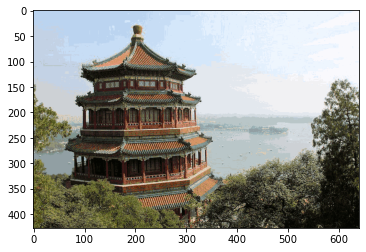

In [19]:
# Imagen con 64 colores
plt.figure()
plt.imshow(recreate_image(gmm_64.means_, labels, w, h))

## 2. Segmentación de clientes

Referencia: https://www.kaggle.com/imakash3011/customer-personality-analysis?select=marketing_campaign.csv

Este ejercicio tiene un componente más libre. En el archivo `marketing_campaign.csv` hay datos de clientes de una compañía. La descripción de las variables es:

Attributes

People

    ID: Customer's unique identifier
    Year_Birth: Customer's birth year
    Education: Customer's education level
    Marital_Status: Customer's marital status
    Income: Customer's yearly household income
    Kidhome: Number of children in customer's household
    Teenhome: Number of teenagers in customer's household
    Dt_Customer: Date of customer's enrollment with the company
    Recency: Number of days since customer's last purchase
    Complain: 1 if customer complained in the last 2 years, 0 otherwise

Products

    MntWines: Amount spent on wine in last 2 years
    MntFruits: Amount spent on fruits in last 2 years
    MntMeatProducts: Amount spent on meat in last 2 years
    MntFishProducts: Amount spent on fish in last 2 years
    MntSweetProducts: Amount spent on sweets in last 2 years
    MntGoldProds: Amount spent on gold in last 2 years

Promotion

    NumDealsPurchases: Number of purchases made with a discount
    AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
    AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
    AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
    AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
    AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
    Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

Place

    NumWebPurchases: Number of purchases made through the company’s web site
    NumCatalogPurchases: Number of purchases made using a catalogue
    NumStorePurchases: Number of purchases made directly in stores
    NumWebVisitsMonth: Number of visits to company’s web site in the last month


Se necesita llevar a cabo clustering sobre los datos. Para este punto pueden usar las características que crean convenientes, o pueden crear nuevas características también. 

Lo más importante es que al final, puedan describir cada segmento de clientes. Es decir, no solo se requiere que hagan el clustering, sino que también identifiquen cómo son los clientes (cuales son las características de los clientes) que pertenecen a cada segmento.

Pueden usar tanto K-Means como GMM. En cualquier caso, no olviden justificar la selección del número de segmentos.

In [2]:
data = pd.read_csv('marketing_campaign.csv',sep='\t')
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


Primero haré una limpieza de datos, las variables categóricas convertirlas a dummies para que sean numéricas.

In [3]:
c=['Education','Marital_Status']
for i in c:
    data=pd.get_dummies(data, columns=[i])

Se cambiará year_birth por Age, Dt_Customer por YearsCustomer, para que sea más fácil de interpretar. También se juntarán las variables kidhome y teenhome.

In [4]:
año=2021
data['Age']=año-data['Year_Birth']
f=data['Dt_Customer'].str.split('-', expand=True).rename(columns={0:'Dt_Customer_Day', 1:'Dt_Customer_month', 2:'Dt_Customer_year'})
df=f.astype('int64')
data['YearsCustomer']=año-df['Dt_Customer_year']

In [5]:
data['Kids']=data['Kidhome']+data['Teenhome']

In [6]:
data.drop(columns=['Dt_Customer','Year_Birth','Kidhome','Teenhome'], inplace=True)

In [7]:
data['Income'].isna().sum()/2240

0.010714285714285714

La variable Income tiene datos nulos, pero al ser un 1.07%, se llenarán con la media.

In [8]:
mean=data['Income'].mean()
data['Income']=data['Income'].fillna(mean)

Para el modelo eliminamos las variables Z_CostContact y Z_Revenue, ya que son coeficientes, además la variable ID.

In [9]:
data.drop(columns=['Z_Revenue','Z_CostContact','ID'], inplace=True)

In [10]:
data.head(2)

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Age,YearsCustomer,Kids
0,58138.0,58,635,88,546,172,88,88,3,8,...,0,0,0,1,0,0,0,64,9,0
1,46344.0,38,11,1,6,2,1,6,2,1,...,0,0,0,1,0,0,0,67,7,2


Los dummies de Marital_status se pueden reducir, ya que algunas separaciones son de lo mismo, como: Marital_Status_Absurd, Marital_Status_Alone, Marital_Status_Divorced, Marital_Status_Single, Marital_Status_Widow, Marital_Status_YOLO. Además podría juntar Marital_Status_Married con Marital_Status_Together, así reduzco las variables a solo 2.

In [11]:
df=data.copy()
data.drop(columns=['Marital_Status_Absurd', 'Marital_Status_Alone',
                   'Marital_Status_Divorced','Marital_Status_Married',
                   'Marital_Status_Single', 'Marital_Status_Together',
                   'Marital_Status_Widow', 'Marital_Status_YOLO'], inplace=True)

In [12]:
data['Marital_Status_Together']=df['Marital_Status_Together']+df['Marital_Status_Married']
data['Marital_Status_Single']=df['Marital_Status_Absurd']+df['Marital_Status_Alone']+df['Marital_Status_Divorced']+df['Marital_Status_Single']+df['Marital_Status_Widow']+df['Marital_Status_YOLO']

In [13]:
data.columns

Index(['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Education_2n Cycle', 'Education_Basic',
       'Education_Graduation', 'Education_Master', 'Education_PhD', 'Age',
       'YearsCustomer', 'Kids', 'Marital_Status_Together',
       'Marital_Status_Single'],
      dtype='object')

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Income,2240.0,52247.251354,25037.797168,1730.0,35538.75,51741.5,68289.75,666666.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0
MntSweetProducts,2240.0,27.062946,41.280498,0.0,1.00,8.0,33.00,263.0
MntGoldProds,2240.0,44.021875,52.167439,0.0,9.00,24.0,56.00,362.0
NumDealsPurchases,2240.0,2.325000,1.932238,0.0,1.00,2.0,3.00,15.0
NumWebPurchases,2240.0,4.084821,2.778714,0.0,2.00,4.0,6.00,27.0


In [15]:
data['MntMeatProducts'].median()

67.0

La variable 'MntMeatProducts' tiene datos atípicos, que afectarán al modelo.

Ahora algunas visualizaciones.

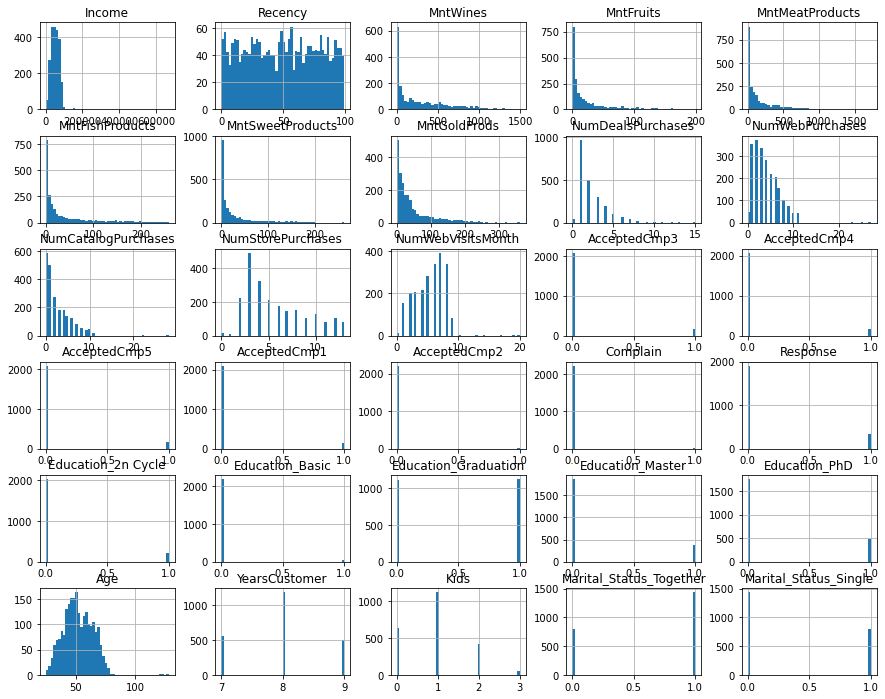

In [15]:
hist=data.hist(bins=50, figsize=([15,12]))

Para el modelo se quita la variable 'MntMeatProducts', ya que hay un dato atípico que cambia todo el modelo, dejando ese dato atípico como un grupo solo.

In [16]:
dat=data.copy()
dat.drop(columns=['MntMeatProducts'], inplace=True)

Primero tenemos que normalizar nuestra base de datos antes de hacer el modelo.

In [17]:
data_norm=Normalizer().fit_transform(dat)

In [18]:
#Elegir número de clusters (k)
kmeans_kwargs = {
       "init": "random",
       "n_init": 10,
       "max_iter": 300,}

#Calculamos la suma del error cuadrático (SSE) para cada "k" de clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_norm)
    sse.append(kmeans.inertia_)

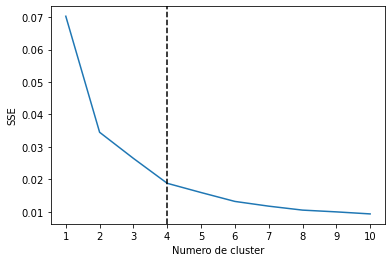

In [19]:
#Graficamos
plt.plot(range(1, 11), sse)
plt.axvline(x=4, ls="--", color="k")
plt.xticks(range(1, 11))
plt.xlabel("Numero de cluster")
plt.ylabel("SSE")
plt.show()

In [20]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

In [21]:
kmeans = KMeans(
       init="random",
       n_clusters=4,
       n_init=10,
       max_iter=300,
       random_state=33)

#Entrenar datos
kmeans.fit(data_norm)

KMeans(init='random', n_clusters=4, random_state=33)

In [22]:
y_kmeans = kmeans.fit_predict(data_norm)
data['Grupo']=y_kmeans

## Visualización

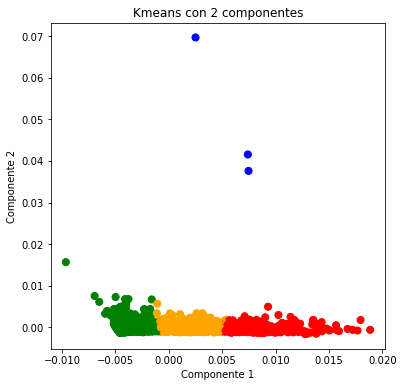

In [23]:
pca=PCA(n_components=2)
pca_data=pca.fit_transform(data_norm)

pca_data_df=pd.DataFrame(data=pca_data, columns=['Componente_1','Componente_2'])
pca_nombres=pd.concat([pca_data_df, data[['Grupo']]], axis=1)

fig= plt.figure(figsize=(6,6))
ax=fig.add_subplot(1,1,1)
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_title('Kmeans con 2 componentes')
color= np.array(['blue','green','orange','red','black','purple'])
ax.scatter(x=pca_nombres['Componente_1'], y=pca_nombres['Componente_2'], c = color[pca_nombres['Grupo']], s=50)
plt.show()

In [24]:
data.head()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Age,YearsCustomer,Kids,Marital_Status_Together,Marital_Status_Single,Grupo
0,58138.0,58,635,88,546,172,88,88,3,8,...,0,1,0,0,64,9,0,0,1,3
1,46344.0,38,11,1,6,2,1,6,2,1,...,0,1,0,0,67,7,2,0,1,1
2,71613.0,26,426,49,127,111,21,42,1,8,...,0,1,0,0,56,8,0,1,0,2
3,26646.0,26,11,4,20,10,3,5,2,2,...,0,1,0,0,37,7,1,1,0,1
4,58293.0,94,173,43,118,46,27,15,5,5,...,0,0,0,1,40,7,1,1,0,1


In [25]:
cero = ((data['Grupo']==0).sum())
uno = ((data['Grupo']==1).sum())
dos = ((data['Grupo']==2).sum())
tres = ((data['Grupo']==3).sum())

print(cero, uno, dos, tres)

3 1170 722 345


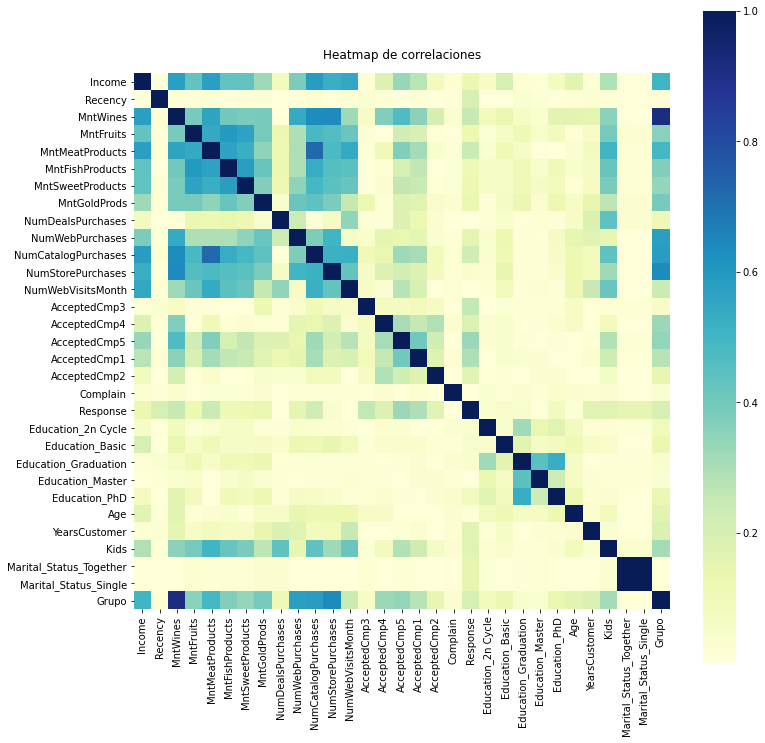

In [26]:
correlations=data.corr().abs()
plt.figure(figsize=(12,12))
ax=sns.heatmap(correlations, square=True, cmap="YlGnBu")
ax.set_title('Heatmap de correlaciones')
ax.set_ylim(len(correlations),-0.5)
plt.show()

Podemos ver que el clustering se fue enfocado en las variables: 
* Income
* -- MntWines -- 
* MntFruits
* MntMeatProducts 
* MntFishProducts 
* MntSweetProducts 
* MntGoldProds
* NumWebPurchases
* NumCatalogPurchases
* NumStorePurchases
* NumWebVisitsMonth
* Kids

In [29]:
data

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Age,YearsCustomer,Kids,Marital_Status_Together,Marital_Status_Single,Grupo
0,58138.0,58,635,88,546,172,88,88,3,8,...,0,1,0,0,64,9,0,0,1,3
1,46344.0,38,11,1,6,2,1,6,2,1,...,0,1,0,0,67,7,2,0,1,1
2,71613.0,26,426,49,127,111,21,42,1,8,...,0,1,0,0,56,8,0,1,0,2
3,26646.0,26,11,4,20,10,3,5,2,2,...,0,1,0,0,37,7,1,1,0,1
4,58293.0,94,173,43,118,46,27,15,5,5,...,0,0,0,1,40,7,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,61223.0,46,709,43,182,42,118,247,2,9,...,0,1,0,0,54,8,1,1,0,3
2236,64014.0,56,406,0,30,0,0,8,7,8,...,0,0,0,1,75,7,3,1,0,2
2237,56981.0,91,908,48,217,32,12,24,1,2,...,0,1,0,0,40,7,0,0,1,3
2238,69245.0,8,428,30,214,80,30,61,2,6,...,0,0,1,0,65,7,1,1,0,2


In [34]:
data[['MntWines','Grupo']].head(20)

,MntWines,Grupo
0,635,3
1,11,1
2,426,2
3,11,1
4,173,1
5,520,2
6,235,2
7,76,1
8,14,1
9,28,1


La separación de grupos se fue hacia la variable MntWines, que es la variable que mide cuanto se ha gastado en alcohol en los últimos 2 años, el grupo 0 son 3 clientes que no gastaron nada en alcohol, el 1 es el grupo que menos gasta, después del grupo 0, y así hasta el grupo 3. Podría hacerse una campaña de alcohol a las personas en el grupo 3 para generar más, ya que se ve que consumen mucho alcohol.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Paulo Adrián Villa Domínguez.
</footer>